# Installation des librairies

In [1]:
!pip install --upgrade pip
!pip install -q -q -q tifffile
!pip install -q -q -q tqdm
!pip install opencv-python-headless
!pip3 install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html



     |████████████████████████████████| 1.6 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 37.1 MB 16.0 MB/s eta 0:00:01    |███████████▎                    | 13.1 MB 1.6 MB/s eta 0:00:16     |██████████████████▋             | 21.5 MB 15.5 MB/s eta 0:00:02     |███████████████████████████████▌| 36.6 MB 16.0 MB/s eta 0:00:01
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 20 kB/s s eta 0:00:01  |▏                               | 4.2 MB 9.0 MB/s eta 0:01:32     |████████▊                       | 227.3 MB 16.0 MB/s eta 0:00:38     |█████████                       | 231.8 MB 18.8 MB/s eta 0:00:32     |██████████▍                     | 270.8 MB 19.2 MB/s eta 0:00:30     |██████████▋                     | 274.6 MB 19.2 MB/s eta 0:00:30     |███████████              

In [6]:
!pip install --upgrade Pillow

     |████████████████████████████████| 3.0 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.0.1
    Uninstalling Pillow-8.0.1:
      Successfully uninstalled Pillow-8.0.1


# Lecture des librairies et framework

In [1]:
%load_ext autoreload
#%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import s3fs
import shutil

import torch.onnx as onnx
import torchvision.models as models

from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
import colorsys
import PIL
from PIL import Image 
from tqdm import tqdm
import matplotlib.patches as mpatches
import time

from framework.dataset import LandCoverData as LCD

device= torch.device("cuda:0" )#if torch.cuda.is_available() else "cpu")
device2=torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print("Using {} device".format(device))
print("Using {} device".format(device2))
print("nom du GPU :", torch.cuda.get_device_name(device=None))
print("GPU initialisé : ", torch.cuda.is_initialized())

Using cuda:0 device
Using cpu device
nom du GPU : Tesla T4
GPU initialisé :  True


# Téléchargement + lecture des images de la BDD

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-challengedata-ens/data/additional_files_earthcube_emu4zqr.zip', 'additional_files_earthcube_emu4zqr.zip')
shutil.unpack_archive('additional_files_earthcube_emu4zqr.zip')

In [164]:
start = time.perf_counter()

DATA_FOLDER_STR = 'dataset'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))


# Trainning and Test

In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, train=True):   # initial logic happens like transform

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms.ToTensor()
       
    def __getitem__(self, idx):
        #tmask = np.empty((0,65536))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        with TiffFile(self.image_paths[idx]) as tif :
            img = tif.asarray()
        if img.dtype == np.uint16:
            scale = 255/2200
            byte_im = (img)*scale
            byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
        with TiffFile(self.mask_paths[idx]) as tif :
            mask = tif.asarray()
        t_image = self.transforms(image)
        t_mask = torch.tensor(mask,dtype = torch.long)
        tmask = self.transforms(mask)
        ID = str(self.mask_paths[idx])
        #retourne un dictionnaire avec comme paramètre image, mask et ID image. 
        return {"image": t_image, "masque" : t_mask, "id" : ID} ### rajouté

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)


In [42]:
dataloader  = trainloader
size = len(dataloader.dataset)
for batch, dico in enumerate(dataloader):
    #dico = dico.to(device)
    images = dico['image'].to(device)
    masques = dico['masque'].to(device)
    batch = masques.shape[0]
    masques = masques.reshape(batch,1,256,256)
    print("Shape of X [N, C, H, W]: ", images.shape, images.dtype)
    print("Shape of y: ", masques,"Shape of X [N, C, H, W]: ", masques.shape, masques.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([20, 4, 256, 256]) torch.float32
Shape of y:  tensor([[[[4, 4, 4,  ..., 4, 6, 6],
          [4, 4, 4,  ..., 4, 6, 6],
          [4, 4, 4,  ..., 6, 3, 3],
          ...,
          [3, 3, 3,  ..., 4, 4, 4],
          [3, 3, 3,  ..., 4, 4, 4],
          [3, 3, 3,  ..., 4, 4, 4]]],


        [[[3, 3, 3,  ..., 6, 6, 6],
          [3, 3, 3,  ..., 3, 3, 6],
          [3, 3, 3,  ..., 3, 3, 3],
          ...,
          [3, 3, 3,  ..., 4, 4, 4],
          [3, 3, 3,  ..., 4, 4, 4],
          [3, 3, 3,  ..., 6, 6, 4]]],


        [[[3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]],


        ...,


        [[[5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          ...,
          [6, 6, 6,  ..., 3, 3, 3],
          [6, 6, 6,  ..., 3, 3, 3],
  

In [36]:
for X, y in trainloader:
    #print(y)
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    #print(y)
    break
#print(y)

[[3 3 4 ... 6 6 6]]
[[6 6 6 ... 6 6 6]]
[[6 6 6 ... 6 6 6]]
[[3 3 3 ... 3 3 3]]
[[3 3 3 ... 6 6 6]]
[[4 6 6 ... 6 6 6]]
[[3 5 5 ... 6 6 6]]
[[6 6 6 ... 4 4 4]]
[[3 3 3 ... 3 3 3]]
[[3 3 3 ... 3 3 3]]
[[5 5 6 ... 3 3 3]]
[[6 4 4 ... 3 3 6]]
[[3 6 6 ... 6 6 6]]
[[5 5 5 ... 3 3 5]]
[[6 6 6 ... 5 5 5]]
[[6 6 6 ... 4 5 5]]
[[4 4 4 ... 3 3 3]]
[[4 5 5 ... 5 5 5]]
[[4 4 4 ... 4 4 4]]
[[3 3 3 ... 2 2 2]]
[[4 4 4 ... 6 6 6]]
[[3 3 3 ... 6 6 6]]
[[3 3 3 ... 6 6 6]]
[[4 4 4 ... 2 2 3]]
[[6 6 6 ... 4 4 4]]
[[7 7 7 ... 9 9 9]]
[[3 3 3 ... 6 6 6]]
[[3 3 3 ... 3 3 3]]
[[6 6 6 ... 6 6 6]]
Shape of X [N, C, H, W]:  torch.Size([20, 4, 256, 256])
Shape of y:  torch.Size([20, 1, 65536]) torch.int64
[[4 4 4 ... 4 4 4]]
[[3 3 3 ... 4 4 4]]
[[3 3 3 ... 6 6 6]]
[[4 4 6 ... 4 4 4]]
[[3 3 3 ... 3 3 3]]
[[6 4 5 ... 6 6 6]]
[[3 3 3 ... 3 3 3]]
[[3 3 3 ... 4 4 6]]
[[4 4 4 ... 6 6 6]]
[[2 2 6 ... 6 6 6]]
[[3 3 3 ... 3 3 3]]


In [19]:
# Define model
from collections import OrderedDict
class NeuralNetwork(nn.Module):
    def __init__(self, in_channels=4, out_channels=10, init_features=32):
        super(NeuralNetwork, self).__init__()
        features = init_features
        self.encoder1 = NeuralNetwork._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = NeuralNetwork._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = NeuralNetwork._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = NeuralNetwork._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = NeuralNetwork._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = NeuralNetwork._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = NeuralNetwork._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = NeuralNetwork._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = NeuralNetwork._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1", nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (name + "conv2",nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

NeuralNetwork = NeuralNetwork()
model = nn.Sequential(
    NeuralNetwork,
    nn.Softmax(1)
)
#model.load_state_dict(torch.load("model_Quentin.pth"))
print("Model chargé")
print(model)




Model chargé
Sequential(
  (0): NeuralNetwork(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1Batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [10]:
params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

2
torch.Size([4096, 65536, 3, 3])


In [26]:
# get some random training images
dataiter = iter(trainloader)
images,masks, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(image))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

RuntimeError: DataLoader worker (pid(s) 5124) exited unexpectedly

In [52]:

# split these path using a certain percentage
len_data = len(train_images_paths)
print(len_data)
train_size = 0.7006651884700665
print(len_data*train_size)
train_image_paths = train_images_paths[:int(len_data*train_size)]
test_image_paths = train_images_paths[int(len_data*train_size):]

train_mask_paths = train_masks_paths[:int(len_data*train_size)]
test_mask_paths = train_masks_paths[int(len_data*train_size):]

batch = 1
#création du train
train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
trainloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
#création du test du train
test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
testloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
end = time.perf_counter()

print("temps en seconde : ", end - start)

18491
12956.0
temps en seconde :  34.79061071714386


In [42]:
dataloader  = trainloader
num_batches = len(dataloader.dataset)*65536
print(num_batches)

849084416


In [17]:
(batch*masques.shape[1]*masques.shape[2])

1310720

In [6]:
dataloader = testloader
size = len(dataloader.dataset)*65536
correct=0
for batch, dico in enumerate(dataloader):
    #dico = dico.to(device)
    images = dico['image'].to(device)
    masques = dico['masque'].to(device)
    #tensor_masque = dico['tensor_masque'].to(device)
    batch = masques.shape[0]
    tmasques = masques.reshape(batch,256,256)
    print("Shape of images [N, C, H, W]: ", images.shape, images.dtype)
    print("Shape of masques [N, C, H, W]:", masques.shape," type",  masques.dtype)
    #print("Shape of tensormasque [N, C, H, W]:", tensor_masque.shape," type",  tensor_masque.dtype)
    pred = model(images)
    print(pred.shape, masques.shape)
    correct += (pred.argmax(1)== masques).type(torch.float).sum().item()
    print(correct/(batch*masques.shape[1]*masques.shape[2])*100, "%")
    print("pred       : ", pred[:,:,0,0], pred.shape)
    print("pred argmax: ", pred.argmax(1)[:,0,0], pred.argmax(1).shape)
    print("masques    : ",  masques[:,0,0], masques.shape)
    #print(torch.sum(pred, dim=1))
    #y = torch.sum(y.view(y.shape[0],y.shape[3]).float(), dim=1)
    #print(y)
    break

Shape of images [N, C, H, W]:  torch.Size([20, 4, 256, 256]) torch.float32
Shape of masques [N, C, H, W]: torch.Size([20, 256, 256])  type torch.int64
torch.Size([20, 10, 256, 256]) torch.Size([20, 256, 256])
8.68682861328125 %
pred       :  tensor([[0.0983, 0.0934, 0.1146, 0.0835, 0.0928, 0.0993, 0.1047, 0.1086, 0.1029,
         0.1019],
        [0.1042, 0.0992, 0.1096, 0.0890, 0.0924, 0.1067, 0.1008, 0.0923, 0.1096,
         0.0961],
        [0.1046, 0.1008, 0.1096, 0.0911, 0.0899, 0.1063, 0.1005, 0.0911, 0.1088,
         0.0972],
        [0.0940, 0.0955, 0.1137, 0.0863, 0.0957, 0.1014, 0.1078, 0.0936, 0.1014,
         0.1105],
        [0.1041, 0.0979, 0.1143, 0.0873, 0.0919, 0.1044, 0.1034, 0.0905, 0.1072,
         0.0991],
        [0.1014, 0.1030, 0.1068, 0.0975, 0.0865, 0.1015, 0.1044, 0.0894, 0.1009,
         0.1085],
        [0.1018, 0.0909, 0.1234, 0.0873, 0.0984, 0.0999, 0.1062, 0.0894, 0.1013,
         0.1015],
        [0.1007, 0.0991, 0.1102, 0.0879, 0.0886, 0.1021, 0.0999, 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [41]:
len(testloader.dataset)

5535

In [35]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, dico in enumerate(dataloader):
        images = dico['image'].to(device)
        masques = dico['masque'].to(device)
        #tensor_masque = dico['tensor_masque'].to(device)
        batch_maques = masques.shape[0]
        #masques = masques.reshape(batch_maques,1,256,256)
        # Compute prediction error
        pred = model(images)
        #print(pred)
        #print("shape of pred:", pred.shape, pred.dtype)
        loss = loss_fn(pred, masques)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0 
    correct = 0
    dic={}
    with torch.no_grad():
        for batch, dico in enumerate(dataloader):
            images = dico['image']
            masques = dico['masque']
            ID = dico['id']
            batch_masques = masques.shape[0]
            #permute(2,0,1).reshape(2,16)
            #tmasques = masques.permute(0,2,3)(batch_masques,256,256)
            #print("batch n°",batch, "batch shape",  batch_masques, "batch pred", images.shape[0])
            pred = model(images)
            #test_loss += loss_fn(pred,masques)
            #t_loss = test_loss.item()
            #print(test_loss)
            correct += (pred.argmax(1)== masques).type(torch.float).sum().item()
    t_loss /= num_batches
    correct /= (size*masques.shape[1]*masques.shape[2])
    print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {t_loss:>8f} \n")
    return dic

# A faire : 
## mettre les pred dan une nouvelles matrices puis reshape en 256x256 sans oublier l'id devant pour afficher les masques avec les masques et images de bases 

## lr=0.07, momentum=0.9 => ~60% accuracy

In [30]:
model = nn.Sequential(
    NeuralNetwork,
    nn.Softmax(1)
)
model.load_state_dict(torch.load('model_Quentin.pth'))
print("model chargé")

model chargé


In [167]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    dic={}
    with torch.no_grad():
        for batch, dico in enumerate(dataloader):
            images = dico['image']
            masques = dico['masque']
            ID = dico['id']
            batch_masques = masques.shape[0]
            #permute(2,0,1).reshape(2,16)
            #tmasques = masques.permute(0,2,3)(batch_masques,256,256)
            #print("batch n°",batch, "batch shape",  batch_masques, "batch pred", images.shape[0])
            pred = model(images)
            print(batch)
            if batch ==1:
                correct += (pred.argmax(1)== masques).type(torch.float).sum().item()
                correct /= (((batch+1)*masques.shape[0]*masques.shape[1]*masques.shape[2]))
                for i, test in enumerate(ID):
                    dic[test] = pred.argmax(1)[i,:,:]
                print(f"Test Error: \n Accuracy: {(100*correct):>8f}%\n")
                return dic
            #test_loss += loss_fn(pred,masques)
            #t_loss = test_loss.item()
            #print(test_loss)
            correct += (pred.argmax(1)== masques).type(torch.float).sum().item()
            
    #t_loss /= num_batches
    #correct /= (size*masques.shape[1]*masques.shape[2])
    #print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {t_loss:>8f} \n")
    return dic

In [168]:
start = time.perf_counter()
epochs = 1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.85)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #train(trainloader, model, loss_fn, optimizer)
    mask_cal = test(testloader, model)
    #print(a.shape)
print("Done!")

end = time.perf_counter()
print("temps en seconde : ", end - start)

Epoch 1
-------------------------------
0
1
Test Error: 
 Accuracy: 84.754181%

Done!
temps en seconde :  0.2230713781900704


In [20]:
torch.save(model.state_dict(), "model_Quentin.pth")
print("Model enregistré")

Model enregistré


In [59]:
# Pour avoir un élément du dataloader (ie un batch)
dico  = next(iter(trainloader)) 
images = dico['image'].to(device)
masques = dico['masque'].to(device)
tensor_masque = dico['tensor_masque'].to(device)

convolution = nn.Conv2d(in_channels= 4, out_channels= 6, kernel_size=3,stride=1)
m = nn.MaxPool2d(3, stride=3)
convolution2 = nn.Conv2d(in_channels= 6, out_channels= 2, kernel_size=6,stride=3)

X_2 = convolution(imges)
M = m(X_2)
X_3 = convolution2(M)
print(X_2.shape)
print(M.shape)
print(X_3.shape)
print(X_3.shape[1]*X_3.shape[2]*X_3.shape[3])
print(F.relu(X_3).shape)

torch.Size([20, 6, 254, 254])
torch.Size([20, 6, 84, 84])
torch.Size([20, 2, 27, 27])
1458
torch.Size([20, 2, 27, 27])


In [23]:
for k, idx in enumerate(random.sample(range(len(train_images_paths)), 1)):
    image_path = train_images_paths[idx]
    mask_path = train_masks_paths[idx]
    assert image_path.name == mask_path.name
    
    with TiffFile(image_path) as tif:
        arr = tif.asarray()        
    with TiffFile(mask_path) as tif:
        mask = tif.asarray()
maskt = torch.tensor(mask).type(torch.LongTensor)

print(mask)
print()
print(maskt)

[[6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 [6 6 6 ... 6 6 6]
 ...
 [3 3 3 ... 6 6 6]
 [3 3 3 ... 6 6 6]
 [3 3 3 ... 6 6 6]]

tensor([[6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        ...,
        [3, 3, 3,  ..., 6, 6, 6],
        [3, 3, 3,  ..., 6, 6, 6],
        [3, 3, 3,  ..., 6, 6, 6]])


In [171]:

#print(f"dataset/train/masks/{idx}.tif")
b = [np.str(a) for a in (train_images_paths)]
test= np.str('dataset/train/images/5017.tif')
print(b[0],"             ",test )
#b[10] = np.str("dataset/train/images/5016.tif")
boole = [c==test for c in b ]
print(boole[boole==True])
print(b[1]==test)
test2 = np.argmax(np.array(boole))
print(test2)
#print(b, where b = f"PosixPath('dataset/train/images/{idx}.tif')")
#f"PosixPath('dataset/train/images/{idx}.tif')" == b[]

dataset/train/images/1.tif               dataset/train/images/5017.tif
False
False
12957


In [ ]:
train_masks_paths

tensor([[4, 4, 4,  ..., 6, 6, 6],
        [4, 4, 4,  ..., 6, 6, 6],
        [4, 4, 4,  ..., 6, 6, 6],
        ...,
        [3, 3, 3,  ..., 4, 4, 4],
        [3, 3, 3,  ..., 4, 4, 4],
        [3, 3, 3,  ..., 4, 4, 4]])
[[4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 ...
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 5 5 5]
 [3 3 3 ... 4 4 4]]
dataset/train/masks/5017.tif
dataset/train/images/5017.tif
no_data_mask 0                no_data_masque 0
clouds_mask     : 0           clouds_masque     : 0
artificial_mask : 42        artificial_masque : 255
cultivated_mask : 31930       cultivated_masque : 30753
broadleaf_mask  : 27197       broadleaf_masque  : 27107
coniferous_mask : 11        coniferous_masque : 900
herbaceous_mask : 6288       herbaceous_masque : 6472
natural_mask    : 0        natural_masque    : 0
snow_mask       : 0           snow_masque       : 0
water_mask      : 68         water_masque      : 49


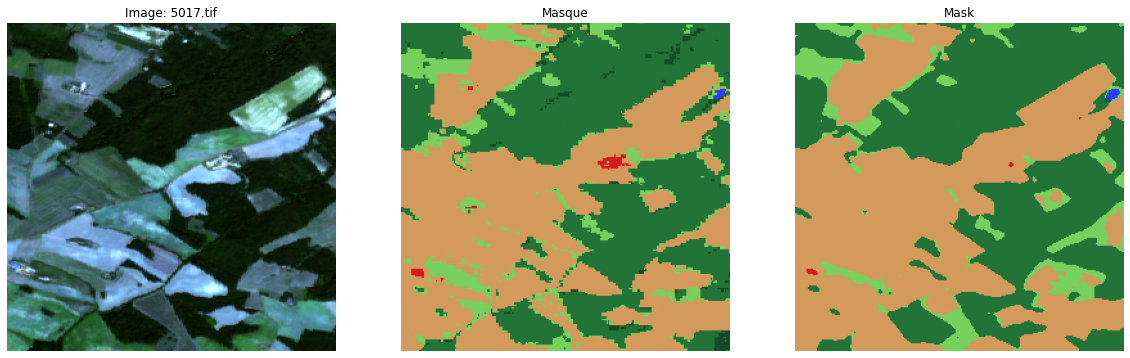

In [174]:

#tester sur image 20243
idx = 5017
mask = mask_cal[f"dataset/train/masks/{idx}.tif"]
#image_path = f"dataset/train/masks/{idx}.tif"
image_path = train_images_paths[12957]
masque_path = train_masks_paths[12957]
assert image_path.name == masque_path.name
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
print(mask)
with TiffFile(image_path) as tif:
    image = tif.asarray()  
if image.dtype == np.uint16:
    iscale = 2200 
    scale = 255 / iscale
    byte_im = (image) * scale
    byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
image = byte_im
colimg = byte_im
with TiffFile(masque_path) as tif :
    colmask = tif.asarray()
    masque = colmask
print(masque)
print(masque_path)
print(image_path)
axs[0].axis("off")
im = axs[0].imshow(image)
classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
show_masque = np.empty((*masque.shape, 3))
show_mask = np.empty((*mask.shape, 3))
classes = LCD.CLASSES
for c, color in classes_colorpalette.items():
    show_mask[mask == c, :] = color
    show_masque[masque == c,:] = color
axs[1].axis("off")

axs[0].set_title(f'Image: {image_path.name}')
axs[1].set_title('Masque')
im = axs[1].imshow(show_masque)
axs[2].set_title('Mask')
im = axs[2].imshow(show_mask)
axs[2].axis("off")
handles = []
for c, color in classes_colorpalette.items():
    handles.append(mpatches.Patch(color=color, label=classes[c]))
    #axs[1].legend(handles=handles)


no_data_test = np.count_nonzero(mask == 0)
clouds_test = np.count_nonzero(mask == 1)
artificial_test = np.count_nonzero(mask ==2)
cultivated_test = np.count_nonzero(mask == 3)
broadleaf_test = np.count_nonzero(mask == 4)
coniferous_test = np.count_nonzero(mask == 5)
herbaceous_test = np.count_nonzero(mask == 6)
natural_test = np.count_nonzero(mask == 7)
snow_test = np.count_nonzero(mask == 8)
water_test = np.count_nonzero(mask == 9)
no_data_colmask = np.count_nonzero(masque == 0)
clouds_colmask = np.count_nonzero(masque == 1)
artificial_colmask = np.count_nonzero(masque ==2)
cultivated_colmask = np.count_nonzero(masque == 3)
broadleaf_colmask = np.count_nonzero(masque == 4)
coniferous_colmask = np.count_nonzero(masque == 5)
herbaceous_colmask = np.count_nonzero(masque == 6)
natural_colmask = np.count_nonzero(masque == 7)
snow_colmask = np.count_nonzero(masque == 8)
water_colmask = np.count_nonzero(masque == 9)

print("no_data_mask", no_data_test, "               no_data_masque", no_data_colmask)
print("clouds_mask     :", clouds_test, "          clouds_masque     :", clouds_colmask)
print("artificial_mask :",artificial_test, "       artificial_masque :",artificial_colmask)
print("cultivated_mask :",cultivated_test, "      cultivated_masque :",cultivated_colmask)
print("broadleaf_mask  :",broadleaf_test, "      broadleaf_masque  :",broadleaf_colmask)
print("coniferous_mask :",coniferous_test, "       coniferous_masque :",coniferous_colmask)
print("herbaceous_mask :",herbaceous_test, "      herbaceous_masque :",herbaceous_colmask)
print("natural_mask    :",natural_test, "       natural_masque    :",natural_colmask)
print("snow_mask       :",snow_test, "          snow_masque       :",snow_colmask)
print("water_mask      :",water_test, "        water_masque      :",water_colmask)

In [170]:
mask_cal

{'dataset/train/masks/5017.tif': tensor([[4, 4, 4,  ..., 6, 6, 6],
         [4, 4, 4,  ..., 6, 6, 6],
         [4, 4, 4,  ..., 6, 6, 6],
         ...,
         [3, 3, 3,  ..., 4, 4, 4],
         [3, 3, 3,  ..., 4, 4, 4],
         [3, 3, 3,  ..., 4, 4, 4]])}

In [3]:
%load_ext autoreload
#%autoreload 2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import s3fs
import shutil

import torch.onnx as onnx
import torchvision.models as models

from pathlib import Path
import random

import numpy as np
from tifffile import TiffFile
import matplotlib.pyplot as plt
import colorsys
import PIL
from PIL import Image 
from tqdm import tqdm
import matplotlib.patches as mpatches
import time

from framework.dataset import LandCoverData as LCD

DATA_FOLDER_STR = 'dataset'
DATA_FOLDER = Path(DATA_FOLDER_STR).expanduser()
# path to the unzipped dataset: contains directories train/ and test/
DATASET_FOLDER = DATA_FOLDER

# get all train images and masks
train_images_paths = sorted(list(DATASET_FOLDER.glob('train/images/*.tif')))
train_masks_paths = sorted(list(DATASET_FOLDER.glob('train/masks/*.tif')))
# get all test images
test_images_paths = sorted(list(DATASET_FOLDER.glob('test/images/*.tif')))
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, train=True):   # initial logic happens like transform

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms.ToTensor()
       
    def __getitem__(self, idx):
        #tmask = np.empty((0,65536))
        if torch.is_tensor(idx):
            idx = idx.tolist()
        with TiffFile(self.image_paths[idx]) as tif :
            img = tif.asarray()
        if img.dtype == np.uint16:
            scale = 255/2200
            byte_im = (img)*scale
            byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
        with TiffFile(self.mask_paths[idx]) as tif :
            mask = tif.asarray()
        t_image = self.transforms(image)
        t_mask = torch.tensor(mask,dtype = torch.long)
        tmask = self.transforms(mask)
        ID = str(self.mask_paths[idx])
        #retourne un dictionnaire avec comme paramètre image, mask et ID image. 
        return {"image": t_image, "masque" : t_mask, "id" : ID} ### rajouté

    def __len__(self):  # return count of sample we have
        return len(self.image_paths)
# Define model
from collections import OrderedDict
class NeuralNetwork(nn.Module):
    def __init__(self, in_channels=4, out_channels=10, init_features=32):
        super(NeuralNetwork, self).__init__()
        features = init_features
        self.encoder1 = NeuralNetwork._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = NeuralNetwork._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = NeuralNetwork._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = NeuralNetwork._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = NeuralNetwork._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = NeuralNetwork._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = NeuralNetwork._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = NeuralNetwork._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = NeuralNetwork._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1", nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),

                    (name + "conv2",nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False,),),
                    (name + "Batchnorm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

NeuralNetwork = NeuralNetwork()
model = nn.Sequential(
    NeuralNetwork,
    nn.Softmax(1)
)
#model.load_state_dict(torch.load("model_Quentin.pth"))



# split these path using a certain percentage
len_data = len(train_images_paths)
train_size = 0.7006651884700665
train_image_paths = train_images_paths[:int(len_data*train_size)]
test_image_paths = train_images_paths[int(len_data*train_size):]

train_mask_paths = train_masks_paths[:int(len_data*train_size)]
test_mask_paths = train_masks_paths[int(len_data*train_size):]

batch = 20
#création du train
train_dataset = CustomDataset(train_image_paths, train_mask_paths, train=True)
trainloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
#création du test du train
test_dataset = CustomDataset(test_image_paths, test_mask_paths, train=False)
testloader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

     
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    dic={}
    with torch.no_grad():
        for batch, dico in enumerate(dataloader):
            images = dico['image']
            masques = dico['masque']
            ID = dico['id']
            batch_masques = masques.shape[0]
            #permute(2,0,1).reshape(2,16)
            #tmasques = masques.permute(0,2,3)(batch_masques,256,256)
            #print("batch n°",batch, "batch shape",  batch_masques, "batch pred", images.shape[0])
            pred = model(images)
            print(batch)
            #test_loss += loss_fn(pred,masques)
            #t_loss = test_loss.item()
            #print(test_loss)
            correct += (pred.argmax(1)== masques).type(torch.float).sum().item()
            for i, test in enumerate(ID):
                dic[test] = pred.argmax(1)[i,:,:]
    #t_loss /= num_batches
    #correct /= (size*masques.shape[1]*masques.shape[2])
    #print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {t_loss:>8f} \n")
    return dic
model = nn.Sequential(
    NeuralNetwork,
    nn.Softmax(1)
)
model.load_state_dict(torch.load('model_Quentin.pth'))
print("model chargé")
epochs = 1


mask_cal = test(testloader, model)

print("Done!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
model chargé
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
2